In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from mylib.visualize import qqplot
from mylib.query_data import query_model, query_observed


from BiasCorrectionLib.BiasCorrection import *
from BiasCorrectionLib.Error import *

sns.set_style('whitegrid')
sns.set_context('paper', rc={"lines.linewidth": 2, 'figure.dpi': 150}, font_scale=1.2)



model_indices = ['tas', 'tasmin', 'tasmax', 'pr']
obs_indices = ['TAVG', 'TMIN', 'TMAX', 'PRCP']
model_path = "./EC-EARTH/hist/"
obs_path = "./observed_clean/"
csv_results_path = './results'
map_df = pd.read_csv("./obs_station_rcm.csv")
bc_index = 'bias_corrected'

select_index = 0
obs_index = obs_indices[select_index]
model_index = model_indices[select_index]


select_station = 57
station = map_df.iloc[select_station]

grid_lat, grid_lon = station['RCMGRID_LAT'], station['RCMGRID_LON']
station_id, station_name = station['STATION'], station['NAME']
station

STATION           TH000048327
NAME           CHIANG MAI, TH
STATION_LON            98.983
STATION_LAT            18.783
RCMGRID_LON           98.9927
RCMGRID_LAT           18.8367
Name: 57, dtype: object

In [11]:
model = query_model(model_path, model_index, grid_lon, grid_lat)
model = model.set_index('DATE')

if model_index == 'pr':
    model[model_index] *= 86400
else:
    model[model_index] -= 273.15

obs = query_observed(obs_path, obs_index, station_id)
obs = obs.set_index('DATE')


merged = model.join(obs, how='inner')
merged.to_csv(f"./results/merged_{obs_index}.csv")
merged = merged.dropna()

train = merged[merged.index < '2000-01-01']
test = merged[merged.index >= '2000-01-01']

bc = Shift()
bc.fit(train[obs_index], train[model_index])

print(bc.c)

train[bc_index] = bc.bias_correction(train[model_index])
test[bc_index] = bc.bias_correction(test[model_index])

-3.806356802272475


c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


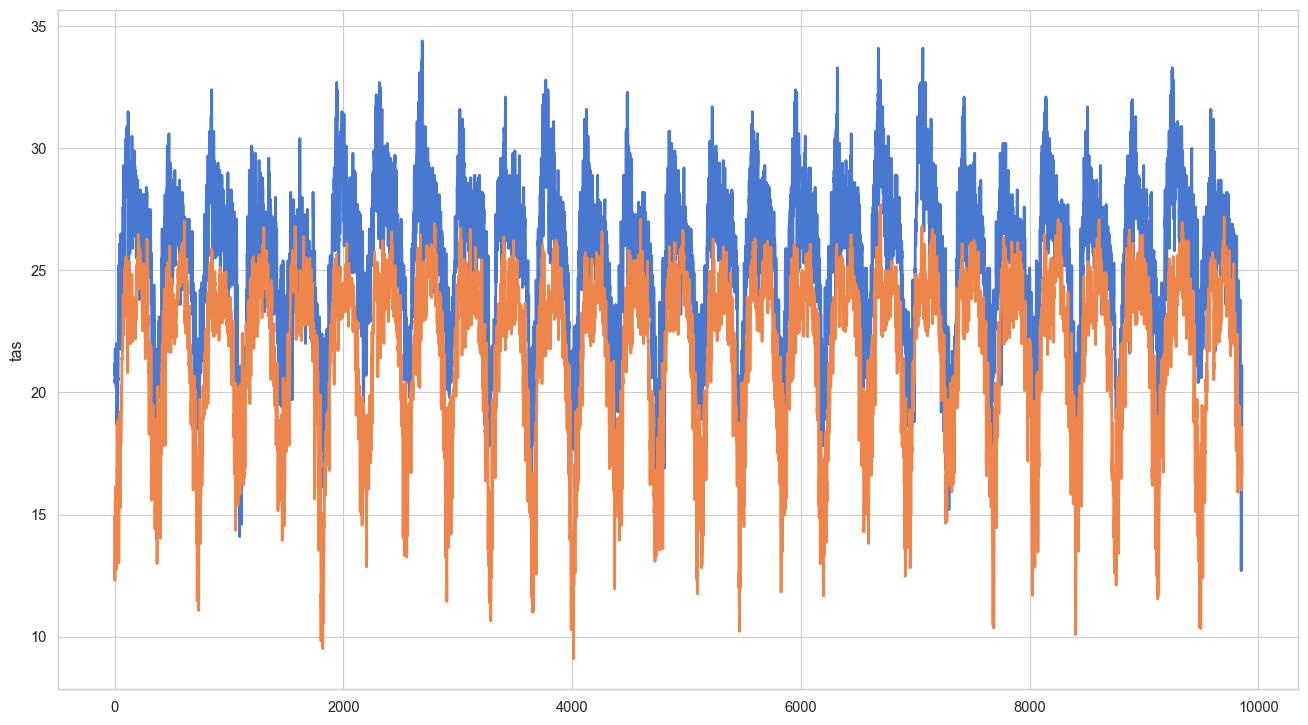

In [12]:
fig = plt.figure(figsize=(16, 9), dpi=100)
sns.lineplot(np.arange(len(train.index)), train[obs_index])
sns.lineplot(np.arange(len(train.index)), train[model_index])

Text(0, 0.5, 'observed TAVG')

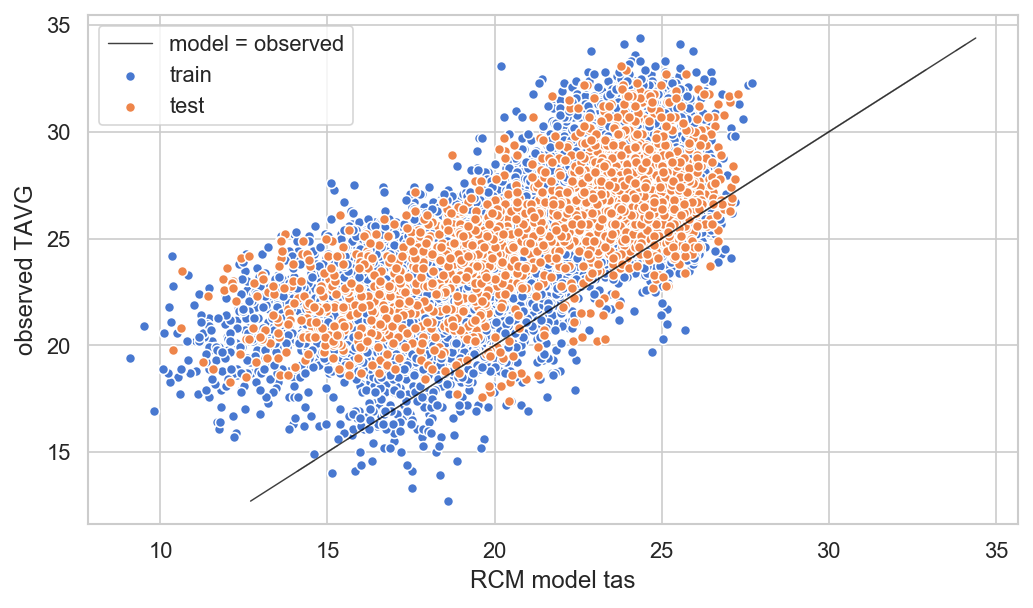

In [13]:
fig = plt.figure(figsize=(8, 4.5), dpi=150)
sns.scatterplot(train[model_index], train[obs_index], label='train')
sns.scatterplot(test[model_index], test[obs_index], label='test')
sns.lineplot(train[obs_index], train[obs_index], color='k', label='model = observed', alpha=0.75, linewidth=0.7)

plt.xlabel(f'RCM model {model_index}')
plt.ylabel(f'observed {obs_index}')

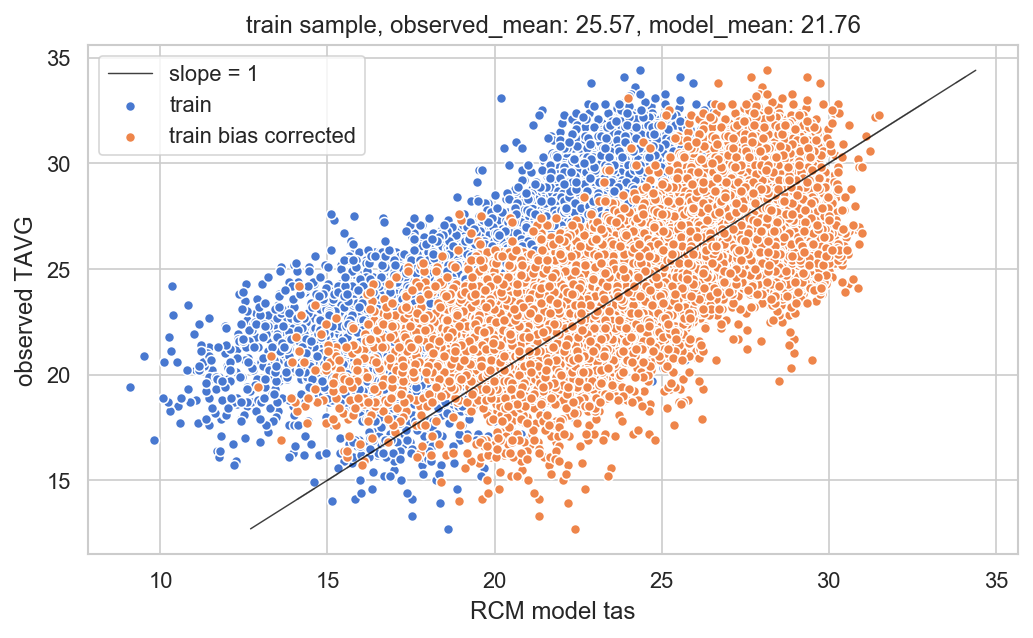

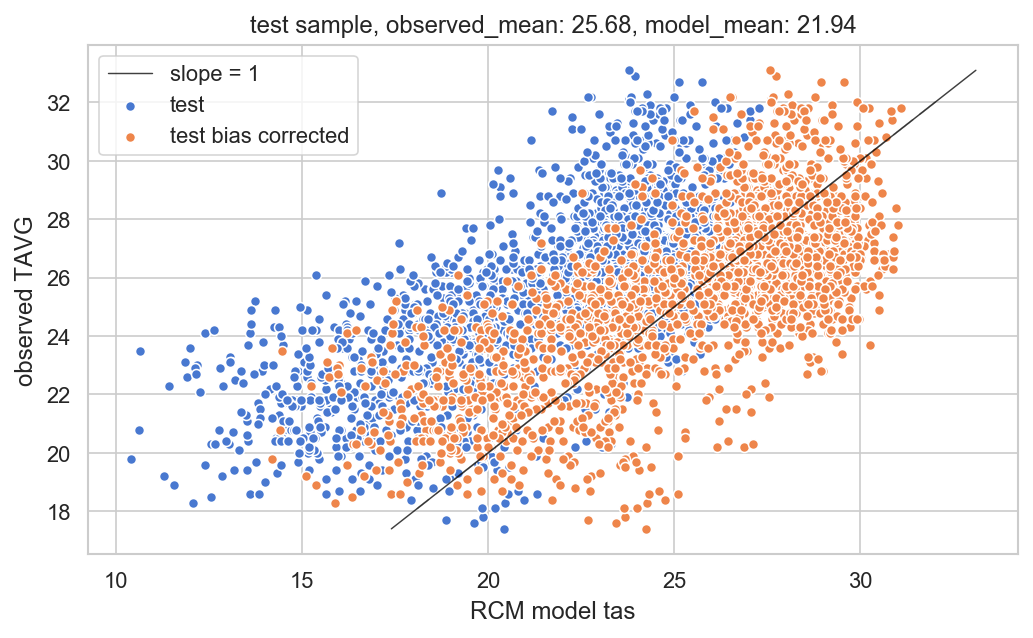

In [14]:
samples = ['train', 'test']
sample_df = {'train': train, 'test': test}

for sample in samples:
    df = sample_df[sample]
    
    fig = plt.figure(figsize=(8, 4.5), dpi=150)
    
    sns.scatterplot(df[model_index], df[obs_index], label=f'{sample}')
    sns.scatterplot(df[bc_index], df[obs_index], label=f'{sample} bias corrected')
    sns.lineplot(df[obs_index], df[obs_index], color='k', alpha=0.75, linewidth=0.7, label='slope = 1')
    
    plt.xlabel(f"RCM model {model_index}")
    plt.ylabel(f"observed {obs_index}")   
    plt.title(f"{sample} sample, observed_mean: {np.round(np.mean(df[obs_index]), 2)}, model_mean: {np.round(np.mean(df[model_index]), 2)}")

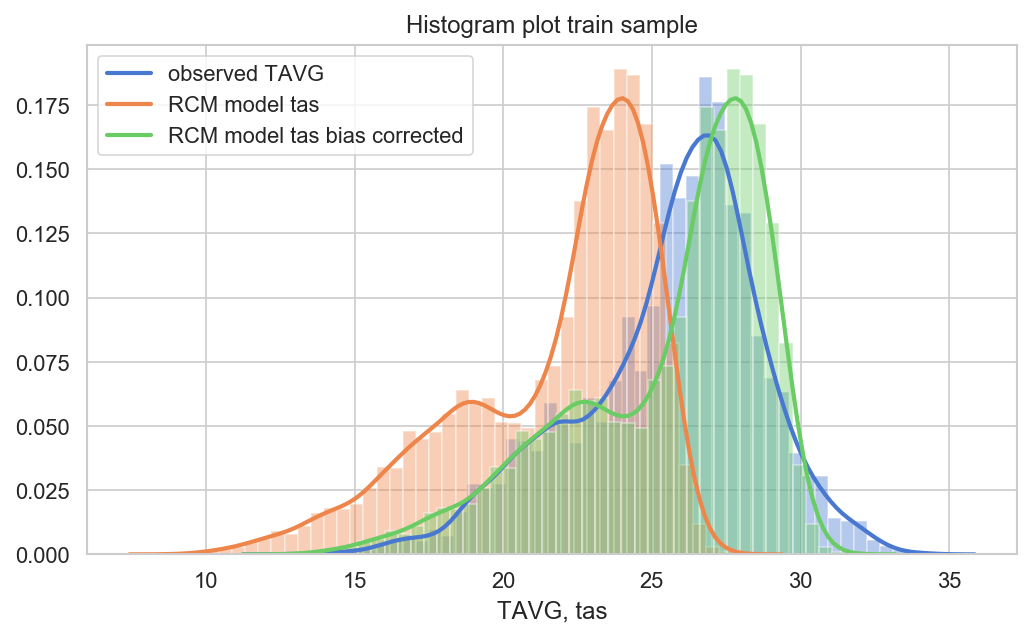

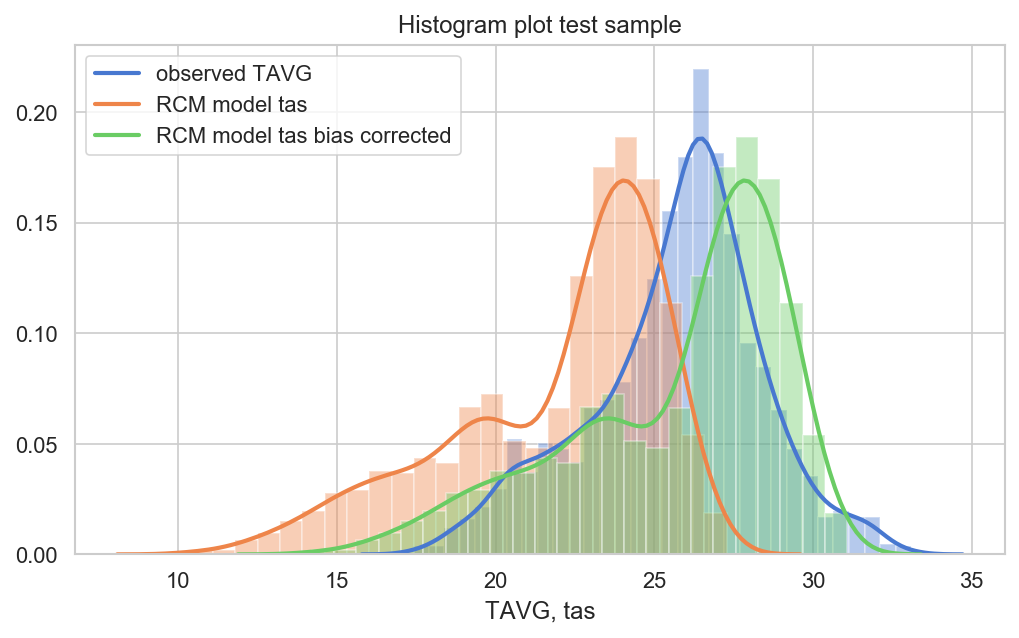

In [15]:
samples = ['train', 'test']
sample_df = {'train': train, 'test': test}

for sample in samples:
    df = sample_df[sample]
    
    fig = plt.figure(figsize=(8, 4.5), dpi=150)
    
    sns.distplot(df[obs_index], kde_kws={"label": f"observed {obs_index}"})
    sns.distplot(df[model_index], kde_kws={"label": f"RCM model {model_index}"})
    sns.distplot(df[bc_index], kde_kws={"label": f"RCM model {model_index} bias corrected"})

    plt.xlabel(f"{obs_index}, {model_index}")
    plt.title(f"Histogram plot {sample} sample")

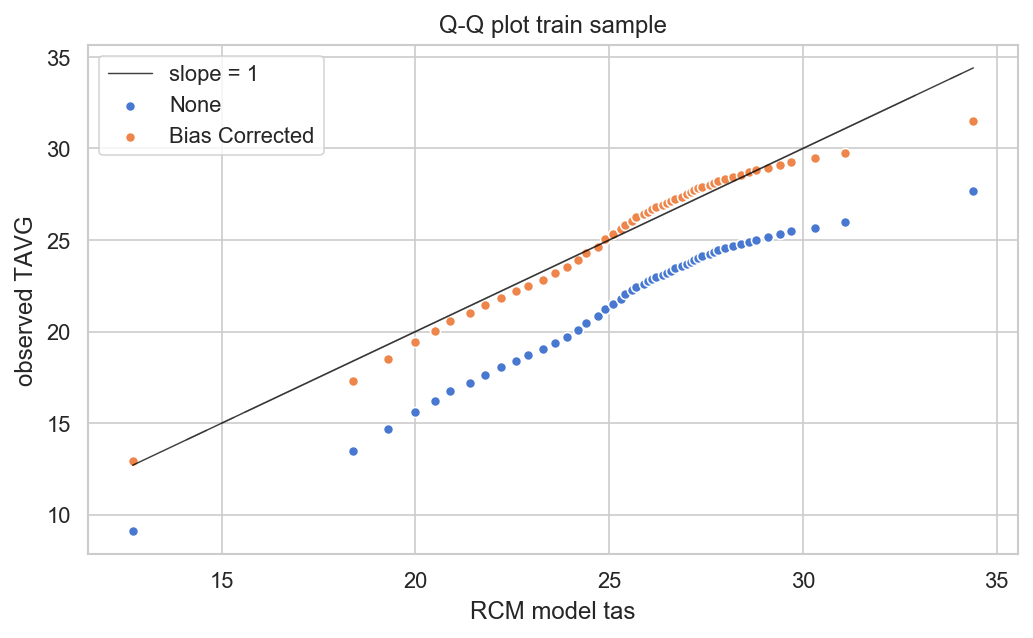

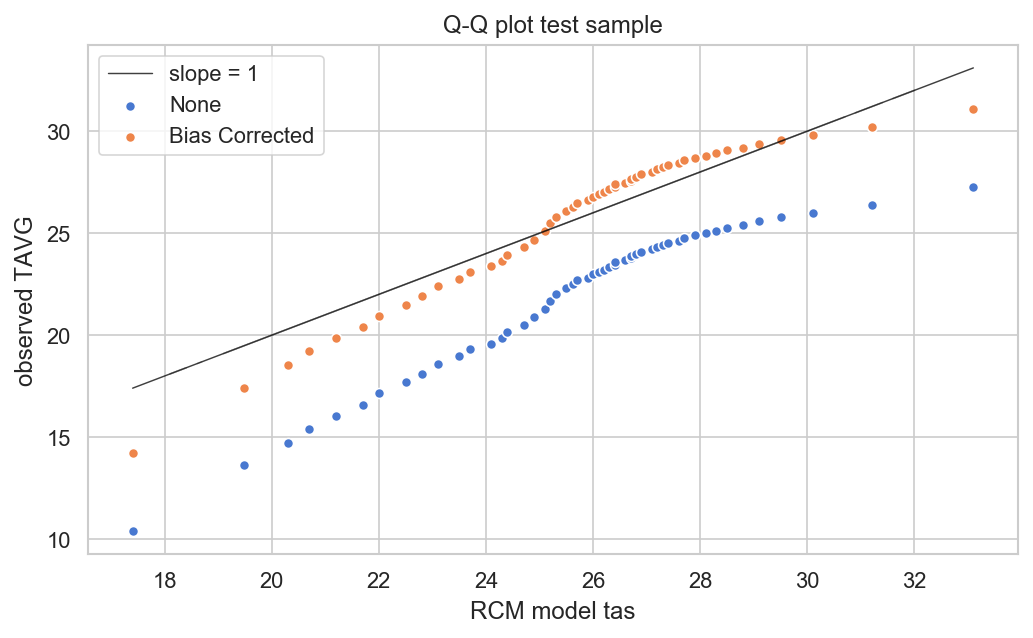

In [16]:
samples = ['train', 'test']
sample_df = {'train': train, 'test': test}

for sample in samples:
    df = sample_df[sample]
    
    fig = plt.figure(figsize=(8, 4.5), dpi=150)
    
    qqplot(df[obs_index], df[model_index], "None")
    qqplot(df[obs_index], df[bc_index], "Bias Corrected")
    sns.lineplot(df[obs_index], df[obs_index], color='k', alpha=0.75, linewidth=0.7, label='slope = 1')

    
    plt.xlabel(f"RCM model {model_index}")
    plt.ylabel(f"observed {obs_index}")   
    plt.title(f"Q-Q plot {sample} sample")

In [17]:
bc.score(train[obs_index], train[model_index])

{'mae_before': 3.905063934259896, 'mae_after': 1.895557295469065}

In [18]:
bc.score(test[obs_index], test[model_index])

{'mae_before': 3.8371391423357464, 'mae_after': 1.9180932760741374}